`Author: Satkar Karki`

`Submitted to: Dr. Bart Hanus` 

`Date: 11/04/2025`

# Customer Segmentation with K-Means Clustering

The goal of this analysis is to **segment customers** and **interpret the characteristics** of each segment using clustering. The dataset provides details on customer demographics, spending behavior, and membership details.

## Phase 1 : Import Dependencies

The first step in the analysis is to import the required libraries for data manipulation, statistical analysis, and visualization.

In [47]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

## Phase 2: Data Preparation

This phase prepares the customer data for clustering analysis. 

The data is loaded using Pandas, and categorical variables are encoded into numeric features through **one-hot encoding**, as clustering algorithms require numeric input. 

Additionally, all numeric features are **standardized** to ensure equal contribution to the clustering process, preventing variables with larger scales from dominating the analysis.

In [48]:
# set the path to the data directory
path_dir = '/Users/satkarkarki/Desktop/usd/past/Learning/clustering-lab/data'

# load the data
raw_data_df = pd.read_csv(os.path.join(path_dir, 'Customer_Clustering_HW_Dataset.csv'))

In [49]:
# display the first few rows of the dataframe
raw_data_df.head()

,CustomerID,Age,Annual_Income,Spending_Score,Credit_Score,Account_Balance,Marital_Status,Employment_Status,Membership_Tier,Region
0,1,46.0,42304.0,26,850.0,4013.0,Married,Student,Silver,East
1,2,38.0,81522.0,64,722.0,4798.0,Married,Unemployed,Gold,North
2,3,48.0,103199.0,98,633.0,1526.0,Single,Self-Employed,Gold,East
3,4,58.0,83584.0,59,669.0,3221.0,Married,Employed,Bronze,North
4,5,37.0,37651.0,56,766.0,1945.0,Single,Self-Employed,Gold,East


In [50]:
# display the last few rows of the dataframe
raw_data_df.tail()

,CustomerID,Age,Annual_Income,Spending_Score,Credit_Score,Account_Balance,Marital_Status,Employment_Status,Membership_Tier,Region
245,246,36.0,74700.0,87,714.0,3033.0,Single,Employed,Bronze,South
246,247,34.0,46330.0,57,712.0,0.0,Single,Employed,Bronze,South
247,248,32.0,61574.0,1,737.0,1099.0,Married,Employed,Bronze,East
248,249,61.0,49239.0,63,720.0,4070.0,Single,Student,Silver,South
249,250,45.0,40110.0,54,749.0,3355.0,Married,Employed,Bronze,North


The next step is encoding the categorical data using the **one-hot-encoder**.

In [51]:
# store the categorical variables in a list
cat_vars = raw_data_df.select_dtypes(include=['object']).columns

# verify that the categorical variables are encoded as object
print(cat_vars)


Index(['Marital_Status', 'Employment_Status', 'Membership_Tier', 'Region'], dtype='object')


In [52]:
# initialize the one-hot-encoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# fit the encoder on the categorical variables
encoded_categorical_data = encoder.fit_transform(raw_data_df[cat_vars])

# verify that the categorical variables are encoded as numeric  
print(encoded_categorical_data)

[[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 [0. 1. 0. ... 1. 0. 0.]]


In [53]:
# create a dataframe from the encoded categorical data
encoded_categorical_df = pd.DataFrame(encoded_categorical_data, columns=encoder.get_feature_names_out(cat_vars))

encoded_categorical_df.head()

,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Employment_Status_Employed,Employment_Status_Self-Employed,Employment_Status_Student,Employment_Status_Unemployed,Membership_Tier_Bronze,Membership_Tier_Gold,Membership_Tier_Platinum,Membership_Tier_Silver,Region_East,Region_North,Region_South,Region_West
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [54]:
# concatenate the encoded categorical data with the original dataframe
df_encoded = pd.concat([raw_data_df, encoded_categorical_df], axis=1)

# turncate the categorical columns as clustering is only done on numeric features
df_encoded = df_encoded.drop(columns=cat_vars)

# display the first few rows of the dataframe
df_encoded.head()

,CustomerID,Age,Annual_Income,Spending_Score,Credit_Score,Account_Balance,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Employment_Status_Employed,...,Employment_Status_Student,Employment_Status_Unemployed,Membership_Tier_Bronze,Membership_Tier_Gold,Membership_Tier_Platinum,Membership_Tier_Silver,Region_East,Region_North,Region_South,Region_West
0,1,46.0,42304.0,26,850.0,4013.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,2,38.0,81522.0,64,722.0,4798.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,3,48.0,103199.0,98,633.0,1526.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,4,58.0,83584.0,59,669.0,3221.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,5,37.0,37651.0,56,766.0,1945.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


### Scaler for Numeric Features

Scaling numeric features is essential for the analysis to produce stable and consistent results. K-Means clustering uses distance calculations (like Euclidean distance) to group similar data points. When features are on vastly different scales (e.g., Annual_Income in thousands vs. Spending_Score from 1-100), features with larger magnitudes dominate the distance calculations, causing the algorithm to ignore smaller-scaled features. Standardization ensures all features contribute equally to cluster formation.

In [55]:
# identify and store the numeric features in a list
num_vars = [col for col in raw_data_df.select_dtypes(include=['number']).columns 
                   if col != 'CustomerID']


# verify that the numeric features are stored in a list
print(num_vars)

['Age', 'Annual_Income', 'Spending_Score', 'Credit_Score', 'Account_Balance']


In [56]:
# initialize the scaler
scaler = StandardScaler()

# fit the scaler on the numeric features
scaler.fit(raw_data_df[num_vars])

# transform the numeric features (scale them)
scaled_numeric = scaler.transform(raw_data_df[num_vars])

# Convert to DataFrame with original column names
scaled_numeric_df = pd.DataFrame(scaled_numeric, columns=num_vars, index=raw_data_df.index)

# Replace the original numeric values in df_encoded with scaled values
df_encoded[num_vars] = scaled_numeric_df[num_vars]

# Verify the scaling worked
print("Scaled numeric features statistics:")
print(df_encoded[num_vars].describe())

Scaled numeric features statistics:
                Age  Annual_Income  Spending_Score  Credit_Score  \
count  2.500000e+02   2.500000e+02    2.500000e+02  2.500000e+02   
mean  -1.421085e-16   1.030287e-16   -2.842171e-17  5.506706e-16   
std    1.002006e+00   1.002006e+00    1.002006e+00  1.002006e+00   
min   -1.943921e+00  -2.551754e+00   -1.613464e+00 -3.258338e+00   
25%   -7.059801e-01  -7.340816e-01   -8.375588e-01 -7.023637e-01   
50%    8.983916e-02  -2.062363e-02   -4.421786e-02  3.266808e-02   
75%    6.203854e-01   6.684938e-01    7.927133e-01  7.072034e-01   
max    3.096268e+00   3.076107e+00    1.804005e+00  2.162143e+00   

       Account_Balance  
count     2.500000e+02  
mean      7.105427e-18  
std       1.002006e+00  
min      -1.931312e+00  
25%      -6.698354e-01  
50%      -1.979349e-02  
75%       6.151011e-01  
max       3.202523e+00  


We have verfied that scaling worked by printing the statistics of the scaled numeric features. The mean is around 0 and the standard deviation is around 1.

In [57]:
# Quick shape verification
print("Shape:", df_encoded.shape)
print(f"\nTotal features: {df_encoded.shape[1]}")
print(f"Total samples: {df_encoded.shape[0]}")
df_encoded.head()

Shape: (250, 21)

Total features: 21
Total samples: 250


,CustomerID,Age,Annual_Income,Spending_Score,Credit_Score,Account_Balance,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Employment_Status_Employed,...,Employment_Status_Student,Employment_Status_Unemployed,Membership_Tier_Bronze,Membership_Tier_Gold,Membership_Tier_Platinum,Membership_Tier_Silver,Region_East,Region_North,Region_South,Region_West
0,1,0.531961,-1.296516,-0.741660,2.162143,1.033869,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,2,-0.175434,0.910618,0.583480,0.613434,1.613901,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,3,0.708810,2.130570,1.769133,-0.463403,-0.803760,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,4,1.593053,1.026665,0.409120,-0.027828,0.448665,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,5,-0.263858,-1.558380,0.304503,1.145803,-0.494163,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [58]:
# Convert the final prepared DataFrame to NumPy array for clustering
# sklearn algorithms (like K-Means) expect NumPy arrays, not DataFrames
datalist = df_encoded.values

# Verify the conversion
print("Data preparation complete!")
print(f"datalist shape: {datalist.shape}")
print(f"datalist type: {type(datalist)}")
print(f"\nFirst few rows of datalist:")
print(datalist[:5, :5])  # Show first 5 rows, first 5 columns

Data preparation complete!
datalist shape: (250, 21)
datalist type: <class 'numpy.ndarray'>

First few rows of datalist:
[[ 1.          0.53196098 -1.29651587 -0.74166045  2.16214283]
 [ 2.         -0.17543394  0.91061843  0.58348047  0.61343392]
 [ 3.          0.70880972  2.13056974  1.76913288 -0.46340275]
 [ 4.          1.59305337  1.02666492  0.40911983 -0.02782836]
 [ 5.         -0.26385831 -1.55838022  0.30450344  1.14580261]]


## Phase 3: Clustering

In [59]:
# define K values (for this assignment: 4, 6, 8)
K = [2, 4, 6, 8]

# initialize dictionaries to store results
result = {}
kmeans_models = {}

# run K-Means for each K value
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(datalist)
    
    # Store the model
    kmeans_models[k] = kmeans
    
    # Store cluster labels with the key format 'k=X_cluster_label'
    result.update({f'k={k}_cluster_label': kmeans.labels_})


In [60]:
kmeans_models

{2: KMeans(n_clusters=2, n_init=10, random_state=0),
 4: KMeans(n_clusters=4, n_init=10, random_state=0),
 6: KMeans(n_clusters=6, n_init=10, random_state=0),
 8: KMeans(n_init=10, random_state=0)}

In [61]:
# calculate silhouette scores (after running K-Means)
silhouette_avg_k2 = silhouette_score(datalist, result['k=2_cluster_label'])
print(f"Silhouette Score for k=2: {silhouette_avg_k2}")


silhouette_avg_k4 = silhouette_score(datalist, result['k=4_cluster_label'])
print(f"Silhouette Score for k=4: {silhouette_avg_k4}")

silhouette_avg_k6 = silhouette_score(datalist, result['k=6_cluster_label'])
print(f"Silhouette Score for k=6: {silhouette_avg_k6}")

silhouette_avg_k8 = silhouette_score(datalist, result['k=8_cluster_label'])
print(f"Silhouette Score for k=8: {silhouette_avg_k8}")

Silhouette Score for k=2: 0.6205460844958375
Silhouette Score for k=4: 0.5541737263120403
Silhouette Score for k=6: 0.5217443573682995
Silhouette Score for k=8: 0.4982445920964419


### Optimal K Selection

Among the required K values (4, 6, 8), **K=4 performs best** with a silhouette score of 0.5542.

However, exploratory analysis revealed that **K=2 achieves a superior silhouette score of 0.6205**, outperforming all tested values. This suggests the customer base naturally forms two distinct segments with better separation and cohesion.

**Recommendation**: While K=4 is optimal among the required set, **K=2 is the data-driven best choice** for customer segmentation, offering both statistical superiority but we are sticking with the desired business granularity and sticking with selecting **k=4** as the optimal choice.

In [62]:
# Output the result of different parameter K to CSV file

# Convert the 'result' dictionary (containing cluster labels for different K) into a pandas DataFrame
cluster_labels_df = pd.DataFrame(result)

# Save the DataFrame to a CSV file using the path_dir variable
cluster_labels_df.to_csv(os.path.join(path_dir, 'Customer_Clustering_result.csv'), index=False, header=True)

print("Cluster labels saved successfully!")
print(f"Saved to: {os.path.join(path_dir, 'Customer_Clustering_result.csv')}")
print(f"Shape: {cluster_labels_df.shape}")
print(f"Columns: {list(cluster_labels_df.columns)}")
cluster_labels_df.head()

Cluster labels saved successfully!
Saved to: /Users/satkarkarki/Desktop/usd/past/Learning/clustering-lab/data/Customer_Clustering_result.csv
Shape: (250, 4)
Columns: ['k=2_cluster_label', 'k=4_cluster_label', 'k=6_cluster_label', 'k=8_cluster_label']


,k=2_cluster_label,k=4_cluster_label,k=6_cluster_label,k=8_cluster_label
0,1,1,3,5
1,1,1,3,5
2,1,1,3,5
3,1,1,3,5
4,1,1,3,5


## Phase 4: Visualization and Inter

Before we visualize the clusters, we need to prepare the data and gather diagnostic information about each clustering solution. 

In [63]:
# Set parameter K and perform t-SNE embedding for visualization

# Define K values (including K=2 for comparison, plus required values)
K = [2, 4, 6, 8]

# Initialize t-SNE for dimensionality reduction to 2 components for visualization
tsne = TSNE(n_components=2, init='pca', random_state=0)
# Fit and transform the processed data (datalist) using t-SNE to get a 2D embedding
embed = tsne.fit_transform(datalist)

# Initialize dictionaries to store cluster labels and models (if not already done)
# Note: These should already exist from previous clustering, but re-initialize if needed
result_viz = {}
kmeans_models_viz = {}

# Loop through each value of K defined in the list
for k in K:
    print(f"When k is: {k}")  # Print the current value of K being processed
    
    # K-Means Algorithm: Initialize and train the KMeans model
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10).fit(datalist)
    # Store the trained KMeans model in the dictionary with K as the key
    kmeans_models_viz[k] = kmeans
    
    # Print the coordinates of the cluster centers for the current K
    print("cluster_centers")
    print(kmeans.cluster_centers_)
    
    # Calculate and print the sample counts for each cluster
    print("sample counts of each cluster:")
    print(np.bincount(kmeans.labels_))  # np.bincount counts the occurrences of each label (cluster)
    
    # Record the cluster labels for each sample for the current K
    result_viz.update({f'k={k}_cluster_label': kmeans.labels_})
    print("-" * 50)

When k is: 2
cluster_centers
[[ 1.88000000e+02  6.72025180e-02 -5.55312245e-02 -3.20823593e-03
   4.29282752e-02  3.69003633e-02  1.20000000e-01  4.32000000e-01
   4.48000000e-01  4.96000000e-01  2.56000000e-01  7.20000000e-02
   1.76000000e-01  3.76000000e-01  2.56000000e-01  8.80000000e-02
   2.80000000e-01  2.40000000e-01  3.28000000e-01  2.24000000e-01
   2.08000000e-01]
 [ 6.30000000e+01 -6.72025180e-02  5.55312245e-02  3.20823593e-03
  -4.29282752e-02 -3.69003633e-02  6.40000000e-02  4.56000000e-01
   4.80000000e-01  5.60000000e-01  1.92000000e-01  8.80000000e-02
   1.60000000e-01  3.68000000e-01  2.16000000e-01  9.60000000e-02
   3.20000000e-01  2.24000000e-01  2.96000000e-01  2.08000000e-01
   2.72000000e-01]]
sample counts of each cluster:
[125 125]
--------------------------------------------------
When k is: 4
cluster_centers
[[ 1.56000000e+02  9.96640852e-02  1.18813310e-01  4.37927525e-02
   7.60718751e-02 -2.93639266e-02  1.11111111e-01  4.76190476e-01
   4.12698413e-01  

In [64]:
# Get column names from the encoded dataframe
feature_names = df_encoded.columns.tolist()

# Create dataframes for cluster centers for k=2, k=4, k=6 and k=8
cluster_centers_k2 = pd.DataFrame(kmeans_models[2].cluster_centers_, columns=feature_names)
cluster_centers_k4 = pd.DataFrame(kmeans_models[4].cluster_centers_, columns=feature_names)
cluster_centers_k6 = pd.DataFrame(kmeans_models[6].cluster_centers_, columns=feature_names)
cluster_centers_k8 = pd.DataFrame(kmeans_models[8].cluster_centers_, columns=feature_names)

In [65]:
print("Cluster Centers for k=2:")
display(cluster_centers_k2)

print("Cluster Centers for k=4:")
display(cluster_centers_k4)

print("Cluster Centers for k=6:")
display(cluster_centers_k6) 

print("Cluster Centers for k=8:")
display(cluster_centers_k8) 


Cluster Centers for k=2:


,CustomerID,Age,Annual_Income,Spending_Score,Credit_Score,Account_Balance,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Employment_Status_Employed,...,Employment_Status_Student,Employment_Status_Unemployed,Membership_Tier_Bronze,Membership_Tier_Gold,Membership_Tier_Platinum,Membership_Tier_Silver,Region_East,Region_North,Region_South,Region_West
0,188.0,0.067203,-0.055531,-0.003208,0.042928,0.0369,0.120,0.432,0.448,0.496,...,0.072,0.176,0.376,0.256,0.088,0.28,0.240,0.328,0.224,0.208
1,63.0,-0.067203,0.055531,0.003208,-0.042928,-0.0369,0.064,0.456,0.480,0.560,...,0.088,0.160,0.368,0.216,0.096,0.32,0.224,0.296,0.208,0.272


Cluster Centers for k=4:


,CustomerID,Age,Annual_Income,Spending_Score,Credit_Score,Account_Balance,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Employment_Status_Employed,...,Employment_Status_Student,Employment_Status_Unemployed,Membership_Tier_Bronze,Membership_Tier_Gold,Membership_Tier_Platinum,Membership_Tier_Silver,Region_East,Region_North,Region_South,Region_West
0,156.0,0.099664,0.118813,0.043793,0.076072,-0.029364,0.111111,0.476190,0.412698,0.460317,...,0.095238,0.222222,0.349206,0.285714,0.063492,0.301587,0.222222,0.349206,0.174603,0.253968
1,32.0,-0.186662,0.020737,0.117965,-0.075841,-0.062497,0.047619,0.428571,0.523810,0.587302,...,0.079365,0.190476,0.428571,0.174603,0.111111,0.285714,0.222222,0.333333,0.158730,0.285714
2,219.0,0.043522,-0.194677,-0.042004,-0.015153,0.091052,0.126984,0.380952,0.492063,0.523810,...,0.047619,0.142857,0.396825,0.222222,0.111111,0.269841,0.253968,0.301587,0.269841,0.174603
3,94.0,0.044902,0.056935,-0.123681,0.015412,0.000835,0.081967,0.491803,0.426230,0.540984,...,0.098361,0.114754,0.311475,0.262295,0.081967,0.344262,0.229508,0.262295,0.262295,0.245902


Cluster Centers for k=6:


,CustomerID,Age,Annual_Income,Spending_Score,Credit_Score,Account_Balance,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Employment_Status_Employed,...,Employment_Status_Student,Employment_Status_Unemployed,Membership_Tier_Bronze,Membership_Tier_Gold,Membership_Tier_Platinum,Membership_Tier_Silver,Region_East,Region_North,Region_South,Region_West
0,191.5,0.165000,-0.161631,-0.174117,-0.185119,-0.145405,0.150000,0.425000,0.425000,0.450000,...,0.050000,0.175000,0.425000,0.225000,0.050000,0.300000,0.275000,0.325000,0.150000,0.250000
1,65.0,-0.035600,0.238439,-0.366177,-0.089169,-0.063062,0.093023,0.441860,0.465116,0.511628,...,0.069767,0.162791,0.325581,0.162791,0.116279,0.395349,0.232558,0.325581,0.139535,0.302326
2,150.5,-0.000691,-0.018990,0.005599,0.186214,0.079271,0.119048,0.547619,0.333333,0.452381,...,0.071429,0.190476,0.309524,0.285714,0.095238,0.309524,0.190476,0.428571,0.190476,0.190476
3,22.0,-0.193941,-0.101221,0.237192,-0.094515,-0.102532,0.046512,0.465116,0.488372,0.674419,...,0.069767,0.162791,0.418605,0.232558,0.069767,0.279070,0.255814,0.279070,0.209302,0.255814
4,231.0,0.028622,-0.054156,0.131037,0.090062,0.135071,0.102564,0.333333,0.564103,0.615385,...,0.076923,0.128205,0.384615,0.256410,0.128205,0.230769,0.256410,0.230769,0.333333,0.179487
5,108.0,0.050768,0.080804,0.166637,0.092320,0.100921,0.046512,0.441860,0.511628,0.465116,...,0.139535,0.186047,0.372093,0.255814,0.093023,0.279070,0.186047,0.279070,0.279070,0.255814


Cluster Centers for k=8:


,CustomerID,Age,Annual_Income,Spending_Score,Credit_Score,Account_Balance,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Employment_Status_Employed,...,Employment_Status_Student,Employment_Status_Unemployed,Membership_Tier_Bronze,Membership_Tier_Gold,Membership_Tier_Platinum,Membership_Tier_Silver,Region_East,Region_North,Region_South,Region_West
0,110.5,0.016152,0.128575,0.118519,0.004436,0.027644,6.666667e-02,0.433333,0.500000,0.433333,...,1.333333e-01,0.166667,0.300000,0.266667,1.333333e-01,0.300000,0.200000,0.333333,0.266667,0.200000
1,202.0,0.152592,-0.284164,-0.270324,-0.075445,0.051403,1.290323e-01,0.483871,0.387097,0.451613,...,-2.775558e-17,0.161290,0.354839,0.193548,9.677419e-02,0.354839,0.193548,0.322581,0.258065,0.225806
2,48.5,-0.258332,0.174287,0.061488,-0.138991,-0.127880,9.375000e-02,0.406250,0.500000,0.562500,...,6.250000e-02,0.187500,0.437500,0.093750,1.562500e-01,0.312500,0.156250,0.406250,0.125000,0.312500
3,141.0,-0.121238,-0.046205,0.040150,0.234453,0.275168,6.451613e-02,0.548387,0.387097,0.387097,...,9.677419e-02,0.258065,0.354839,0.193548,1.290323e-01,0.322581,0.129032,0.354839,0.290323,0.225806
4,234.0,-0.044137,-0.055303,0.139653,0.036335,0.114282,1.212121e-01,0.303030,0.575758,0.606061,...,9.090909e-02,0.121212,0.424242,0.272727,1.212121e-01,0.181818,0.303030,0.272727,0.272727,0.151515
5,16.5,-0.147801,-0.108309,0.160656,-0.035390,-0.009657,-4.163336e-17,0.468750,0.531250,0.625000,...,9.375000e-02,0.187500,0.406250,0.281250,6.250000e-02,0.250000,0.281250,0.250000,0.218750,0.250000
6,80.0,0.132625,0.031383,-0.331069,0.002615,-0.033570,9.677419e-02,0.516129,0.387097,0.612903,...,6.451613e-02,0.096774,0.322581,0.225806,3.225806e-02,0.419355,0.258065,0.193548,0.225806,0.322581
7,171.5,0.296163,0.170834,0.070860,-0.025409,-0.309415,1.666667e-01,0.400000,0.433333,0.533333,...,1.000000e-01,0.166667,0.366667,0.366667,-4.163336e-17,0.266667,0.333333,0.366667,0.066667,0.233333


Cluster centers are the average customer profile for each segment. Each row is one segment, each column is one feature, and each value is the average for that feature within that segment. This helps us understand and characterize the customer segments.

#### Compare Features

Now that we've identified our customer segments through clustering, we need to understand what makes each segment unique. This phase focuses on comparing the characteristics of different customer clusters, specifically looking at **categorical features** (like age, annual income, region, etc.) that were converted into binary format through one-hot encoding.

In [66]:
# Compare One-Hot Encoded Features for k=4

print("\nComparison of One-Hot Encoded Features across all 4 Clusters (k=4)")
print("=" * 100)

one_hot_cols = [col for col in cluster_centers_k4.columns if '_' in col]

# Create a comparison DataFrame for easier viewing
comparison_df = cluster_centers_k4[one_hot_cols].T
comparison_df.columns = [f'Cluster {i}' for i in range(4)]
comparison_df = comparison_df.round(4)

print(comparison_df)


Comparison of One-Hot Encoded Features across all 4 Clusters (k=4)
                                 Cluster 0  Cluster 1  Cluster 2  Cluster 3
Annual_Income                       0.1188     0.0207    -0.1947     0.0569
Spending_Score                      0.0438     0.1180    -0.0420    -0.1237
Credit_Score                        0.0761    -0.0758    -0.0152     0.0154
Account_Balance                    -0.0294    -0.0625     0.0911     0.0008
Marital_Status_Divorced             0.1111     0.0476     0.1270     0.0820
Marital_Status_Married              0.4762     0.4286     0.3810     0.4918
Marital_Status_Single               0.4127     0.5238     0.4921     0.4262
Employment_Status_Employed          0.4603     0.5873     0.5238     0.5410
Employment_Status_Self-Employed     0.2222     0.1429     0.2857     0.2459
Employment_Status_Student           0.0952     0.0794     0.0476     0.0984
Employment_Status_Unemployed        0.2222     0.1905     0.1429     0.1148
Membership_Tier_Bron

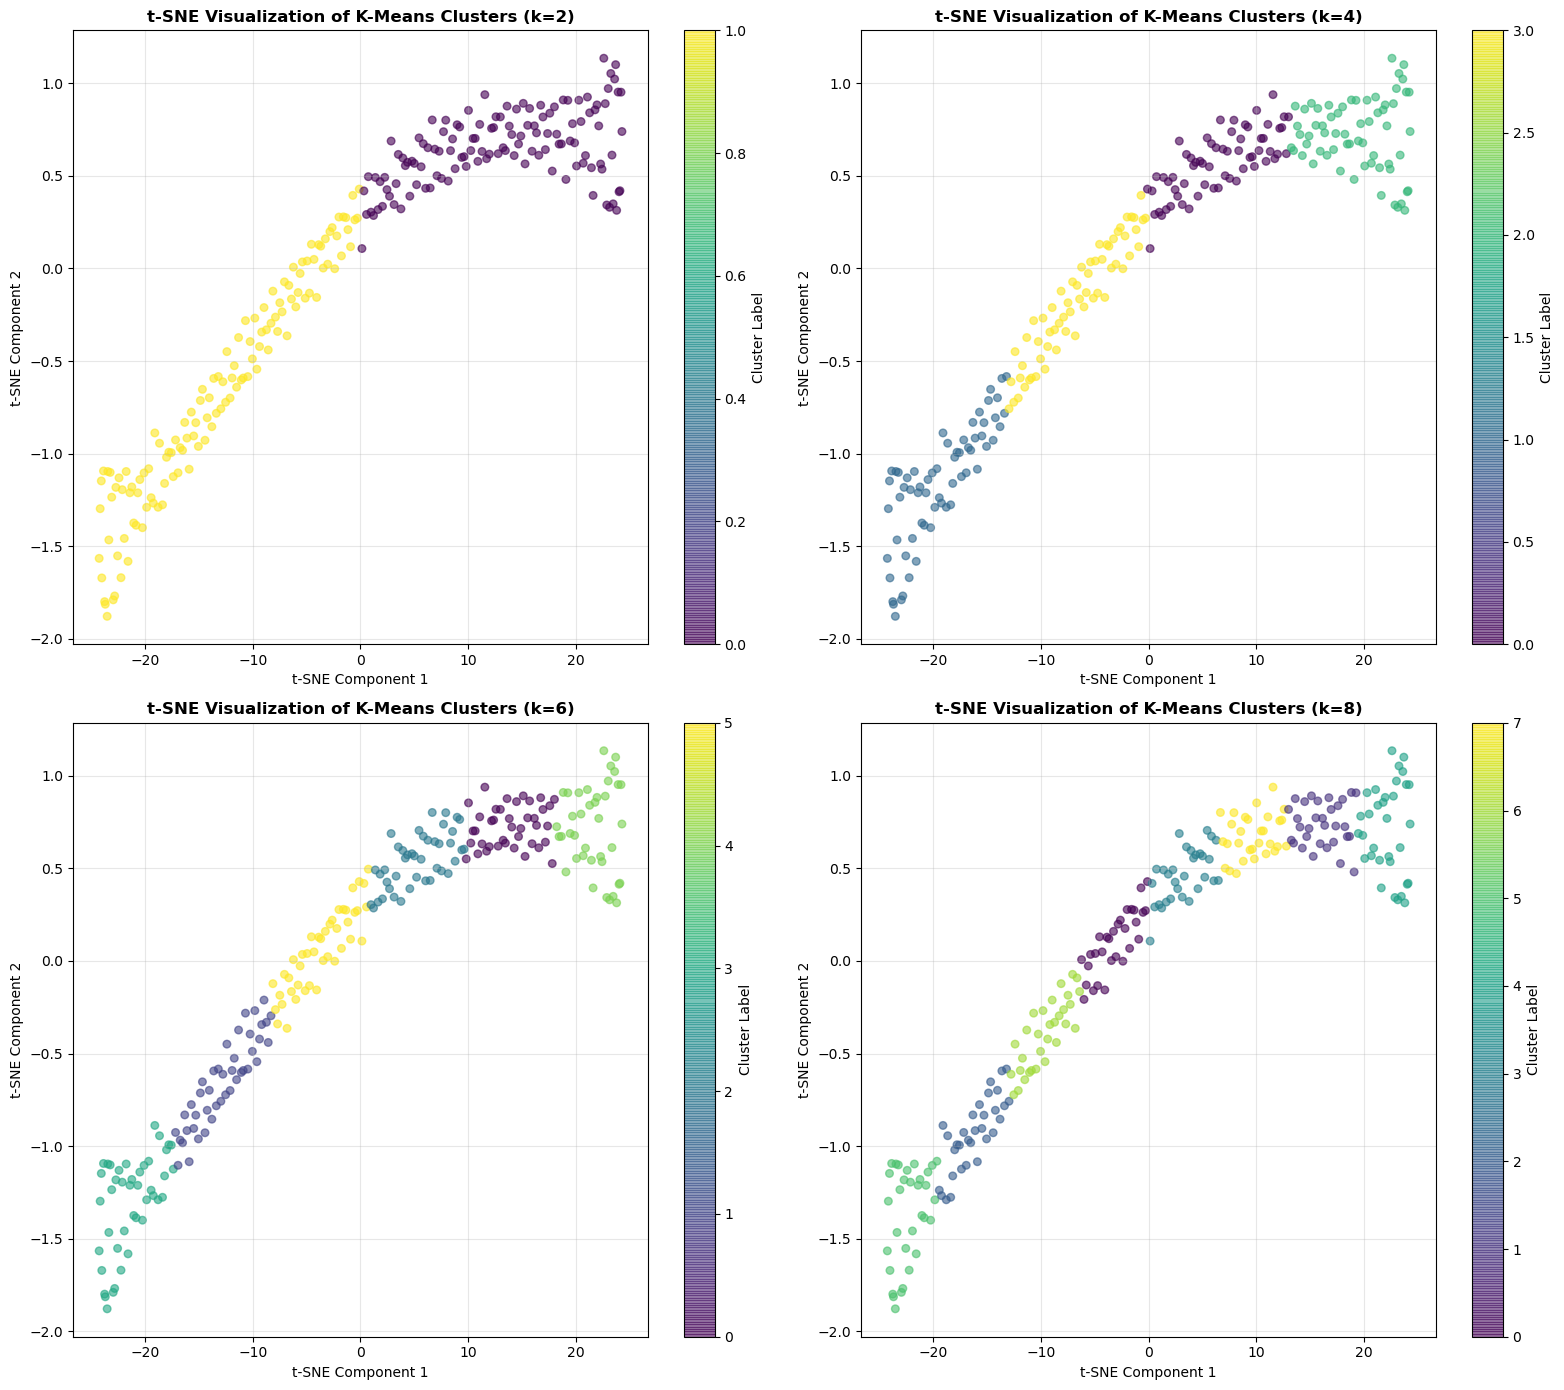

In [67]:
# Visualize Clusters with t-SNE
# Create separate plots for each K value to assess cluster separation

K_values = [2, 4, 6, 8]

# Create subplots for each K value
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.ravel()

for idx, k in enumerate(K_values):
    ax = axes[idx]
    
    # Scatter plot with cluster labels as colors
    scatter = ax.scatter(embed[:, 0], embed[:, 1], 
                        c=result[f'k={k}_cluster_label'], 
                        cmap='viridis', 
                        s=30, 
                        alpha=0.6)
    
    ax.set_title(f't-SNE Visualization of K-Means Clusters (k={k})', fontsize=12, fontweight='bold')
    ax.set_xlabel('t-SNE Component 1', fontsize=10)
    ax.set_ylabel('t-SNE Component 2', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Add colorbar
    plt.colorbar(scatter, ax=ax, label='Cluster Label')

plt.tight_layout()
plt.show()

## Phase 4: Interpretation

### 1. What does each cluster represent?

**Cluster 0: High-Income, Creditworthy Professionals**
- Represents affluent customers with highest income (0.12) and credit scores (0.08)
- Moderate spending behavior (0.04), indicating financial discipline
- Demographics: Employed professionals (46%), Gold membership tier (29%), concentrated in North region (35%)
- Profile: Financially stable professionals who spend responsibly

**Cluster 1: High-Spending, Moderate-Income Customers**
- Represents active spenders with highest spending score (0.12) despite lower income (0.02)
- Lower credit scores (-0.08), suggesting potential financial stress
- Demographics: Primarily single (52%), most employed (59%), Bronze membership (43%)
- Profile: Young professionals or singles who spend aggressively relative to income

**Cluster 2: Value-Conscious, Low-Income Savers**
- Represents budget-conscious customers with lowest income (-0.19) but highest savings (0.09)
- Low spending (-0.04), indicating price sensitivity
- Demographics: More self-employed (29%), higher divorce rate (13%), South region (27%)
- Profile: Financially constrained customers who prioritize saving over spending

**Cluster 3: Conservative, Moderate-Income Customers**
- Represents stable customers with moderate income (0.06) and lowest spending (-0.12)
- Balanced credit scores and account balances
- Demographics: Primarily married (49%), Silver membership (34%), West region (25%)
- Profile: Family-oriented, conservative spenders seeking long-term value

---

### 2. How do the clusters differ in terms of age, income, spending score, and membership tier?

| Cluster | Income | Spending Score | Credit Score | Account Balance | Membership Tier |
|---------|--------|----------------|--------------|-----------------|-----------------|
| **Cluster 0** | Highest (0.12) | Moderate (0.04) | Highest (0.08) | Moderate (-0.03) | Gold (29%) |
| **Cluster 1** | Lower (0.02) | **Highest (0.12)** | **Lowest (-0.08)** | Lower (-0.06) | Bronze (43%) |
| **Cluster 2** | **Lowest (-0.19)** | Low (-0.04) | Low (-0.02) | **Highest (0.09)** | Bronze (40%) |
| **Cluster 3** | Moderate (0.06) | **Lowest (-0.12)** | Moderate (0.02) | Balanced (0.00) | Silver (34%) |

**Key Differences:**
- **Income**: Cluster 0 has highest income; Cluster 2 has lowest
- **Spending**: Cluster 1 spends most; Cluster 3 spends least
- **Credit Score**: Cluster 0 has best credit; Cluster 1 has worst credit
- **Membership Tier**: Cluster 0 has most Gold members; Clusters 1 & 2 have more Bronze members; Cluster 3 has most Silver members

---

### 3. Which cluster might represent the most valuable customers?

**Cluster 0 represents the most valuable customers.**

**Justification:**
- **Highest income (0.12)**: Greater spending capacity and revenue potential
- **Highest credit score (0.08)**: Lower default risk, more reliable payments
- **Gold membership (29%)**: Indicates higher engagement and loyalty
- **Moderate spending with high income**: Indicates financial stability and potential for upselling
- **Low risk profile**: Strong creditworthiness suggests lower churn and higher lifetime value

While Cluster 1 has higher spending, Cluster 0's combination of high income, strong credit, and financial stability makes them the most valuable segment for long-term business growth.

---

### 4. Which cluster might represent the highest-risk customers?

**Cluster 1 represents the highest-risk customers.**

**Justification:**
- **Lowest credit score (-0.08)**: Indicates past payment issues or high credit risk
- **Highest spending (0.12) with lower income (0.02)**: Spending exceeds income capacity, suggesting potential debt accumulation
- **Lower account balance (-0.06)**: Limited savings buffer, vulnerable to financial shocks
- **High spending-to-income ratio**: Unsustainable financial behavior pattern
- **Bronze membership (43%)**: May indicate newer customers with unproven payment history

This combination of low credit, overspending relative to income, and limited savings creates the highest default and churn risk in the portfolio. Requires enhanced credit monitoring and risk management strategies.

## Phase 5: Reflection

This segmentation reveals that customer value depends on the interaction of income, spending behavior, credit risk, and demographic factors—not just income alone. Marketing managers gain actionable insights: high-income customers (Cluster 0) offer upselling potential through premium programs; high-spending, lower-income customers (Cluster 1) require credit risk monitoring and financial wellness initiatives; value-conscious customers (Cluster 2) respond to discount strategies; and conservative customers (Cluster 3) prefer family-oriented, trust-building messaging. These insights guide retention by enabling targeted interventions—implementing VIP loyalty programs for high-value segments while providing financial education for high-risk segments to reduce churn. For promotions, the segmentation enables personalized campaigns: premium upselling for Cluster 0, flexible payment options for Cluster 1, value bundles for Cluster 2, and family packages for Cluster 3, ultimately improving conversion rates and optimizing marketing ROI through data-driven customer understanding.